<a href="https://colab.research.google.com/github/SaifullahKatpar/PySpark/blob/master/NY_Taxi_x06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Spark

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.3.4/spark-2.3.4-bin-hadoop2.7.tgz
!tar xf spark-2.3.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
# Install dependencies
!pip install pyshp

     |████████████████████████████████| 225kB 4.9MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-cp36-none-any.whl size=32609 sha256=037e4b9853ac0a4147f7802022a565677ef393b2c78b61da816f9a2b6ef2d74d
  Stored in directory: /root/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp


In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.4-bin-hadoop2.7"

import findspark
findspark.init()


In [0]:
# Import the PySpark module
from pyspark.sql import SparkSession

# Create SparkSession object
spark = SparkSession.builder \
                    .master('local[*]') \
                    .appName('test') \
                    .config("spark.driver.memory", "12g")\
                    .getOrCreate()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# import os
# os.listdir(r'/content/gdrive/My Drive/')

In [0]:
# spark.sparkContext._conf.getAll()

# Libaries

In [0]:
from pyspark import SparkFiles
from pyspark.sql.types import IntegerType, TimestampType, DoubleType, StringType, DoubleType, StructType, StructField, LongType,FloatType
from pyspark.sql.functions import col, dayofweek, hour, datediff, minute,to_timestamp, radians, asin, sin, sqrt, cos, lit
from pyspark.sql import DataFrame

import pyarrow.parquet as pq
from functools import reduce
import time
import pandas as pd
import shapefile
import seaborn as sns
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


 # 2. Loading data as parquet files

##Part-I

## 1. Read without imposing a schema.

**Answer:** Read with inferSchema as None. If None is set, it uses the default value, false.


In [0]:
url_2015 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-05.csv"
spark.sparkContext.addFile(url_2015)
df_2015 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2015-05.csv"), header=True)


In [0]:
url_2018 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-05.csv"
spark.sparkContext.addFile(url_2018)
df_2018 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-05.csv"), header=True)


##2. Inspect the inferred schema. Do you agree with Spark’s typing decision?

**Answer:** No. I disagree with the inferred schema as it sets the datatype of every column to string regardless of the value present in column

In [0]:
df_2015.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- RateCodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)



In [0]:
df_2018.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)



##3. Eventually correct the schema and read again the data.

**Answer**: There are two ways to correct the schema. 


**1. While reading data, set inferSchema = True. It requires one extra pass over the data to get the input schema automatically from data.**


In [0]:
# df_2015_inferred = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2015-01.csv"), header=True, inferSchema = True)

In [0]:
# df_2018_inferred = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-01.csv"), header=True, inferSchema = True)

In [0]:
# df_2015_inferred.printSchema()
# df_2018_inferred.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropof

**2. Force schema**

In [0]:
schema_2015 = StructType([
    StructField("VendorID", IntegerType()),
    StructField("tpep_pickup_datetime", TimestampType()),
    StructField("tpep_dropoff_datetime", TimestampType()),
    StructField("passenger_count", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("RateCodeID", IntegerType()),
    StructField("store_and_fwd_flag", StringType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", IntegerType()),
    StructField("fare_amount", DoubleType()),
    StructField("extra", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("improvement_surcharge", DoubleType()),
    StructField("total_amount", DoubleType())
])

schema_2018 = StructType([
    StructField("VendorID", IntegerType()),
    StructField("tpep_pickup_datetime", TimestampType()),
    StructField("tpep_dropoff_datetime", TimestampType()),
    StructField("passenger_count", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("RateCodeID", IntegerType()),
    StructField("store_and_fwd_flag", StringType()),
    StructField("PULocationID", IntegerType()),
    StructField("DOLocationID", IntegerType()),
    StructField("payment_type", IntegerType()),
    StructField("fare_amount", DoubleType()),
    StructField("extra", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("improvement_surcharge", DoubleType()),
    StructField("total_amount", DoubleType())
])

In [0]:
url_2015 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-05.csv"
spark.sparkContext.addFile(url_2015)
df_2015_schema = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2015-05.csv"), header=True, nullValue='NA', schema=schema_2015)

In [0]:
url_2018 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-05.csv"
spark.sparkContext.addFile(url_2018)
df_2018_schema = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-05.csv"), header=True, nullValue='NA', schema=schema_2018)

## 4. Save the data into parquet files given number of partitions and partition column

In [0]:
# df_2015_schema.repartition(1).write.partitionBy('VendorID').mode(
# "overwrite").parquet("data/df_2015.parquet")

In [0]:
df_2015_schema.repartition(1).write.partitionBy('VendorID').mode(
"overwrite").parquet("/content/gdrive/My Drive/data/df_2015.parquet")

KeyboardInterrupt: ignored

In [0]:
df_2018_schema.repartition(1).write.partitionBy('VendorID').mode(
"overwrite").parquet("data/df_2018.parquet")

In [0]:
df_2015_schema=None
df_2018_schema=None


In [0]:
# import gc
# collected = gc.collect()
# print("Garbage collector: collected %d objects.",collected)

##Part-II
**1. What is the StorageLevel of the dataframe after reading the csv files?**

**Answer:** df.storageLevel(useDisk, useMemory, useOffHeap, deserialized, replication)

In [0]:
df_2015.storageLevel

StorageLevel(False, False, False, False, 1)

In [0]:
df_2018.storageLevel

StorageLevel(False, False, False, False, 1)

**2. What is the number of partitions of the dataframe?**

**Answer:**

In [0]:
df_2015.rdd.getNumPartitions()

15

In [0]:
df_2018.rdd.getNumPartitions()

6

**3.Is it possible to tune this number at loading time?**

**Answer:** Yes, we can tune the number of partitions at loading time with coalesce(n).

In [0]:
df_2015_tuned = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2015-01.csv"), header=True, nullValue='NA', schema=schema_2015).coalesce(10)


In [0]:
df_2018_tuned = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-01.csv"), header=True, nullValue='NA', schema=schema_2018).coalesce(3)


In [0]:
df_2015_tuned.rdd.getNumPartitions()

10

In [0]:
df_2018_tuned.rdd.getNumPartitions()

3

**4. Why would we want to modify the number of partitions when creating the parquet files?**

**Answer:** Becaue we want to utilize the distributive power of Spark and process data efficiently.

#3. Investigate (at least) one month of data in 2015
The following longitudes and lattitudes encompass Newark and JFK airports, Northern Manhattanand Verazzano bridge

**Read parquet files**

In [0]:
parque_2015_df = spark.read.option("mergeSchema", "true").parquet("data/df_2015.parquet")

In [0]:
parque_2015_df.show(2)

+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|VendorID|
+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+
| 2015-05-05 23:37:40|  2015-05-05 23:40:36|              1|         0.54|-73.93083953857422|40.744789123535156|         1|             

In [0]:
long_min=-74.10
long_max=-73.70
lat_min=40.58
lat_max=40.90

Using these boundaries,filter the 2015 data(using pickup and dropoff longitude andlatitude) and count the number of trips for each value of passenger_count and make a plot of that.

In [0]:
filtered_df = parque_2015_df.filter( 
    (func.round(col('pickup_longitude'),2)>= long_min) & 
    (func.round(col('pickup_longitude'),2)<= long_max ) &
    (func.round(col('pickup_latitude'),2)>= lat_min ) & 
    (func.round(col('pickup_latitude'),2)<=  lat_max) &
    (func.round(col('dropoff_longitude'),2)>= long_min) & 
    (func.round(col('dropoff_longitude'),2)<= long_max ) &
    (func.round(col('dropoff_latitude'),2)>= lat_min ) & 
    (func.round(col('dropoff_latitude'),2)<=  lat_max) 
    )

In [0]:
filtered_df.count()

12896295

In [0]:
passenger_grouped = filtered_df.groupBy('passenger_count').count()

In [0]:
passenger_grouped.show()

+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|              1|9038276|
|              6| 465291|
|              3| 553508|
|              5| 701952|
|              9|      5|
|              4| 261812|
|              8|      6|
|              7|     10|
|              2|1872418|
|              0|   3017|
+---------------+-------+



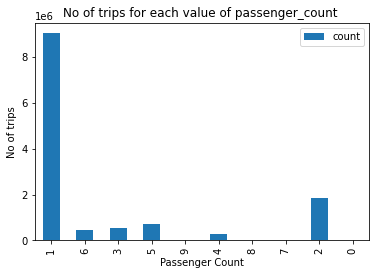

In [0]:
group_df = passenger_grouped.toPandas()
ax = group_df.plot(kind='bar',x='passenger_count',y='count', title = 'No of trips for each value of passenger_count ') 
ax.set_xlabel("Passenger Count")
ax.set_ylabel("No of trips")
plt.show()

**1.What’s special with trips with zero passengers**

These trips do not have anything worth analysing. These trips have mostly 0 trip distance and were charged for that. It means these trips may either be mistakenly booked by the customer or made by the capton to complete his rides.


In [0]:
trips_0 = filtered_df.filter(col('passenger_count')==0)

In [0]:
trips_0.show()

2.What’s special with trips with more than 6 passengers?

There are only 21 trips, which is not significant among the total trips. Trip distance is mostly zero. These trips are outliers and may not add anything to our anlysis. 



In [0]:
trips_6 = filtered_df.filter(col('passenger_count')>6)

In [0]:
trips_6.show()

3.What is the largest distance travelled during this month? Is it the first taxi on the moon?

In [0]:
max_dist = filtered_df.agg({"trip_distance": "max"}).collect()

In [0]:
print('Max distance travelled OMG =D : ', max_dist[0][0])

In [0]:
filtered_df.filter(col('trip_distance')==15700000.0).show()

4.Plot the distribution of the trip_distance(using an histogram for instance) during year 2105. Focus on trips with non-zero trip distance and trip distance less than 30 miles.

In [0]:
# parque_2015_df = spark.read.option("mergeSchema", "true").parquet("data/df_2015.parquet")
df_dist = pq.read_pandas('data/df_2015.parquet', columns=['trip_distance']).to_pandas()
filtered_dist = df_dist[(df_dist['trip_distance']>0)&(df_dist['trip_distance']<30) ]

In [0]:
plt.ticklabel_format(style = 'plain')
plt.hist(filtered_dist['trip_distance'], bins=[0,5,10,15,20,25,30])
plt.ylabel('Count of Trip Distances')
plt.xlabel('Trip Distance')
plt.title('Histogram of Trip Distances')
plt.show()


# Let’s look at what Spark does for these computations

1.Use the explain method or have a look at the Spark UIto analyze the job. You should be able to assess 
- Parsed Logical Plan
- Analyzed Logical Plan
- Optimized Logical Plan
- Physical Plan


2.Do the Analyzed Logical Plan and Optimized Logical Plan differ? Spot the differences if any.How would a RDBMS proceed with such a query?

3.How does the physical plan differ from the Optimized Logical Plan? What are the keywordsyou would not expects in a RDBMS? What is their meaning?

4.Inspect the stages on Spark UI. How many stages are necessary to complete the Spark job? What are the roles of HashAggregate and Exchange hashpartitioning?

5.Does the physical plan performshuffleoperations? If yes how many?

6.What are tasks with respect to stages (in Spark language)? How many tasks are your stagesmade of?

**Now, compute the following and produce relevant plots:**

1.Break down the trip distance distribution for each day of week

2.Count the number of distinct pickup location

3.Compute and display tips and profits as a function of the pickup location

#4  Investigate one month of trips data in 2015 and 2018


Consider one month of trips data from yellow taxis for each year

1. Filter and cache/persist the result

In [0]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

sf = shapefile.Reader("taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc=df_loc[['LocationID','longitude','latitude']]


In [0]:
loc_schema = StructType([
    StructField("LocationID", IntegerType()),
    StructField("longitude", DoubleType()),
    StructField("latitude", DoubleType())])
dfspark_loc=spark.createDataFrame(df_loc, schema=loc_schema )

In [0]:
dfspark_loc=dfspark_loc.select(col('LocationID').alias('PULocationID'),col('longitude'),col('latitude'))
parque_2018_df = spark.read.option("mergeSchema", "true").parquet("data/df_2018.parquet")
PULocation_df = parque_2018_df.join( dfspark_loc ,on='PULocationID',how='left')
PULocation_df=PULocation_df.withColumnRenamed('longitude','pickup_longitude').withColumnRenamed('latitude','pickup_latitude')

In [0]:
dfspark_loc = dfspark_loc.select(col('PULocationID').alias('DOLocationID'),col('longitude'),col('latitude'))
df_2018_updated = PULocation_df.join( dfspark_loc ,on='DOLocationID',how='left')
df_2018_updated=df_2018_updated.withColumnRenamed('longitude','dropoff_longitude').withColumnRenamed('latitude','dropoff_latitude')
df_2018_updated=reduce(DataFrame.drop, ['DOLocationID','PULocationID'], df_2018_updated)


In [0]:
def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)
ny_taxi_df =unionAll(parque_2015_df,df_2018_updated)


**Persist** 

In [0]:
import pyspark
ny_taxi_df.persist(pyspark.StorageLevel.MEMORY_AND_DISK)

DataFrame[tpep_pickup_datetime: timestamp, tpep_dropoff_datetime: timestamp, passenger_count: int, trip_distance: double, pickup_longitude: double, pickup_latitude: string, RateCodeID: int, store_and_fwd_flag: string, dropoff_longitude: double, dropoff_latitude: double, payment_type: double, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, VendorID: double]

In [0]:
# ny_taxi_df.repartition(1).write.partitionBy('VendorID').mode(
# "overwrite").parquet("data/NY-Taxi.parquet")

In [0]:
# parque_df = spark.read.option("mergeSchema", "true").parquet("data/NY-Taxi.parquet")

## 4.1  Assessing seasonalities and looking at time series

Compute and plot the following time series indexed by day of the week and hour of day:

1. The number of pickups
2. The average fare
3. The average trip duration
4. Plot the average number of ongoing trips

In [0]:
### Extract day of week and hour from date in pyspark
ny_taxi_df = ny_taxi_df.withColumn('pickup_weekday',dayofweek(ny_taxi_df.tpep_pickup_datetime))\
.withColumn('pickup_hour',hour(ny_taxi_df.tpep_pickup_datetime))\
.withColumn('trip_duration', func.round((col('tpep_dropoff_datetime').cast(LongType()) - col('tpep_pickup_datetime').cast(LongType()))/60))


In [0]:
weekday_group = ny_taxi_df.groupBy('pickup_weekday')
hour_group = ny_taxi_df.groupBy('pickup_hour')


## Number of Pickups
### By Day of Week

In [0]:
df_weekday = weekday_group.count().toPandas()
df_weekday=df_weekday.sort_values(by=['pickup_weekday'])
df_weekday.head()

,pickup_weekday,count
0,1,3001701
6,2,2536909
2,3,3175314
4,4,3302749
3,5,3373637


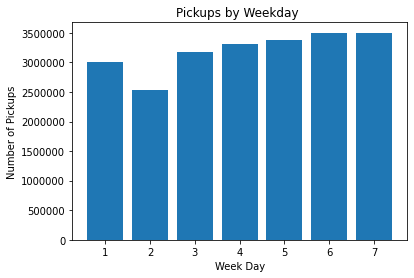

In [0]:
plt.ticklabel_format(style = 'plain')
plt.bar(df_weekday['pickup_weekday'],df_weekday['count'])
plt.ylabel('Number of Pickups')
plt.xlabel('Week Day')
plt.title('Pickups by Weekday ')
plt.show()


### By Hour of Day

In [0]:
df_hour = hour_group.count().toPandas()
df_hour = df_hour.sort_values(by=['pickup_hour'])
df_hour.head()

,pickup_hour,count
22,0,808185
2,1,584985
21,2,425564
6,3,302649
13,4,232366


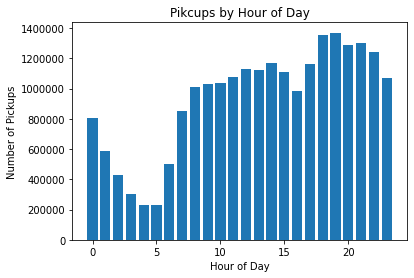

In [0]:

plt.ticklabel_format(style = 'plain')
plt.bar(df_hour['pickup_hour'],df_hour['count'])
plt.ylabel('Number of Pickups')
plt.xlabel('Hour of Day')
plt.title('Pikcups by Hour of Day')
plt.show()


## The Average Fair
### By Day of Week 

In [0]:
df_weekday = weekday_group.agg({'fare_amount':'avg'}).toPandas()
df_weekday=df_weekday.sort_values(by=['pickup_weekday'])
df_weekday.head()

,pickup_weekday,avg(fare_amount)
0,1,8.895706
6,2,8.009160
2,3,7.147505
4,4,7.230321
3,5,7.355028


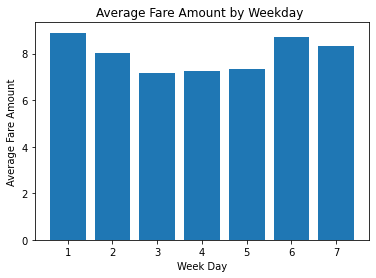

In [0]:
plt.ticklabel_format(style = 'plain')
plt.bar(df_weekday['pickup_weekday'],df_weekday['avg(fare_amount)'])
plt.ylabel('Average Fare Amount')
plt.xlabel('Week Day')
plt.title('Average Fare Amount by Weekday ')
plt.show()


### By Hour of Day

In [0]:
df_hour = hour_group.agg({'fare_amount':'avg'}).toPandas()
df_hour = df_hour.sort_values(by=['pickup_hour'])
df_hour.head()

,pickup_hour,avg(fare_amount)
22,0,8.972439
2,1,8.972266
21,2,8.943936
6,3,9.283550
13,4,10.399923


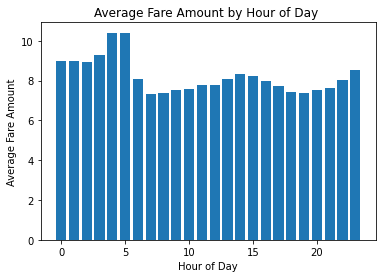

In [0]:
plt.ticklabel_format(style = 'plain')
plt.bar(df_hour['pickup_hour'],df_hour['avg(fare_amount)'])
plt.ylabel('Average Fare Amount')
plt.xlabel('Hour of Day')
plt.title('Average Fare Amount by Hour of Day ')
plt.show()


## The Average Trip Duration
### By Day of Week

In [0]:

df_weekday = weekday_group.agg({'trip_duration':'avg'}).toPandas()
df_weekday=df_weekday.sort_values(by=['pickup_weekday'])
df_weekday.head()

,pickup_weekday,avg(trip_duration)
0,1,15.126047
6,2,15.442356
2,3,16.620033
4,4,14.128325
3,5,17.812253


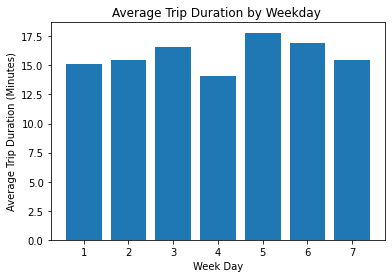

In [0]:
plt.ticklabel_format(style = 'plain')
plt.bar(df_weekday['pickup_weekday'],df_weekday['avg(trip_duration)'])
plt.ylabel('Average Trip Duration (Minutes)')
plt.xlabel('Week Day')
plt.title('Average Trip Duration by Weekday ')
plt.show()


### By Hour of Day

In [0]:
df_hour = hour_group.agg({'trip_duration':'avg'}).toPandas()
df_hour = df_hour.sort_values(by=['pickup_hour'])
df_hour.head()

,pickup_hour,avg(trip_duration)
22,0,14.967452
2,1,14.044784
21,2,13.612818
6,3,13.692406
13,4,14.511917


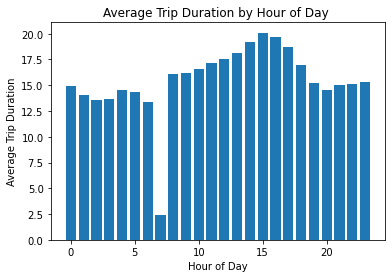

In [0]:
plt.ticklabel_format(style = 'plain')
plt.bar(df_hour['pickup_hour'],df_hour['avg(trip_duration)'])
plt.ylabel('Average Trip Duration')
plt.xlabel('Hour of Day')
plt.title('Average Trip Duration by Hour of Day ')
plt.show()


## Average Number of Ongoing Trips

In [0]:
# import gc
# collected = gc.collect()
# print("Garbage collector: collected %d objects.",collected)

Garbage collector: collected %d objects. 20212


##4.2  Rides to the airports

In order to find the longitude and lattitude of JFK and Newark airport as well as the longitudeand magnitudes of Manhattan, you can use a service like geojson.io. Plot the following time series,indexed the day of the week and hour of the day

In [0]:
JFK_lon = -73.78
JFK_lat = 40.64
SM_lon = 74.00
SM_lat = 40.72


In [0]:

# def find_median(values_list):
#     try:
#         median = np.median(values_list) #get the median of values in a list in each row
#         return func.round(float(median),2)
#     except Exception:
#         return None #if there is anything wrong with the given values
# median_finder = func.udf(find_median,FloatType())

In [0]:

ny_taxi_df = ny_taxi_df.withColumn("dlon", radians(lit(-73.778139)) - radians(col("pickup_longitude"))) \
  .withColumn("dlat", radians(lit(40.641311)) - radians(col("pickup_latitude"))) \
  .withColumn("haversine_dist", func.round(asin(sqrt(
                                         sin(col("dlat") / 2) ** 2 + cos(radians(col("pickup_longitude")))
                                         * cos(radians(lit(40.641311))) * sin(col("dlon") / 2) ** 2
                                         )
                                    ) * 2 * 3963 * 5280,1)) \
  .drop("dlon", "dlat")

ModuleNotFoundError: ignored

1. Median duration of taxi trip leaving Midtown (Southern Manhattan) headed for JFK Airport

2. Median taxi duration of trip leaving from JFK Airport to Midtown (Southern Manhattan)

##4.3  Geographic information

For this, you will need to find tools to display maps and to build choropeth maps. We let you lookand find relevant tools to do this.

1. Build a heatmap where color is a function of
   1. number ofpickups
   2. number ofdropoffs
   3. number ofpickupswith dropoff at some airport (JFK, LaGuardia, Newark)

2. Build a choropeth map where color is a function of
  1. number of pickups in the area
  2. ratio of number of payments by card/number of cash payments for pickups in the area 
  3. ratio of total fare/trip duration for dropoff in the area

3. Build an interactive chorophet with a slider allowing the user to select anhour of dayandwhere the color is a function of
  1. average number of dropoffs in the area during that hour the day 
  2. average ratio of tip over total fare amount for pickups in the area at given hour of theday